In [1]:
import numpy as np
import pandas as pd
from dython.nominal import associations
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomTreesEmbedding, RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# this reformat function is shared by all models and called by the model-specific ones
def shared_reformat(df):
    df = deepcopy(df)
    
    # create special targets (only on train set)
    if "max_price" in list(df):
        df["delta_abs"] = df["max_price"] - df["min_price"] 
        df["delta_rel"] = np.log(df["max_price"] / df["min_price"] )
    
    # create new features
    df["cpu_brand"] = df.cpu.str.split(n=1).str[0]
    df["cpu_type"] = df.cpu.str.split(n=1).str[1]
    df["gpu_brand"] = df.gpu.str.split(n=1).str[0]
    df["gpu_series"] = df.gpu.str.split(n=2).str[1]
    df["os_type"] = df.os_details.str.split(n=1).str[1]
    df["os_nr"] = df.os_details.str.split(n=2).str[2]
    df["resolution"] = df.pixels_y / df.screen_size
    
    # correct a few mistakes
    map_gpu_series = {"GeFoce":"GeForce", "RadeonÂ": "Radeon"}
    df.gpu_series = df.gpu_series.map(map_gpu_series) 
    
    # make sure all values in categorical variables are strings
    cat_col = df.select_dtypes(include=['object']).columns
    df[cat_col] = df[cat_col].astype(str)
    
    # cleanup test set
    df.pixels_y = df.pixels_y.fillna(0)
    df.pixels_y = df.pixels_y.astype('int64')
    
    return df

In [4]:
# I no longer use delta_abs and delta_rel
targets = ["max_price", "delta_abs", "delta_rel", "min_price"]

In [5]:
## HUBER ##
def reformat_huber(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols = ["touchscreen", "screen_surface", "gpu_series", "ram", "detachable_keyboard", "os",
                "pixels_y", "os_type", "os_nr", "id", "pixels_x", "gpu_brand", "name", "cpu_type",
                ]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .99)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [6]:
## RANDOM FOREST REGRESSOR ##
def reformat_rfr(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "gpu_series", "pixels_x", "screen_surface", "os", "os_details", "cpu_brand",
              "detachable_keyboard", "touchscreen", "os_nr", "screen_size", "cpu_details", "brand",
              "gpu_brand"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .8)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [7]:
# this preprocessor is the same for all models, but doesn't have to be
def create_preprocessor(df_pp):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
        ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        #('ordinal', OrdinalEncoder(),
        #('scaler', StandardScaler()),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ])

    numeric_features = df_pp.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df_pp.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

In [8]:
# permutation variable importance
def var_importance(pipe, X, Y, scoring=None):
    perm_imp = permutation_importance(pipe, X, Y, scoring=scoring, n_repeats=10, n_jobs=None, random_state=None)
    sorted_idx = perm_imp.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(perm_imp.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()

In [9]:
# create X and Y
def create_xy(df, targets):
    X = df.drop(targets, axis=1)
    Y_max = df.max_price
    Y2 = df.delta_abs
    Y3 = df.delta_rel
    Y_min = df.min_price 
    return X, Y_max, Y2, Y3, Y_min

gemiddeld: 149.30668788638866, details: [111.97258958 196.09787558 141.01804198 159.22997619 158.6693399
 148.89786827 139.57829443 152.45678006 177.68559892 107.46051395]


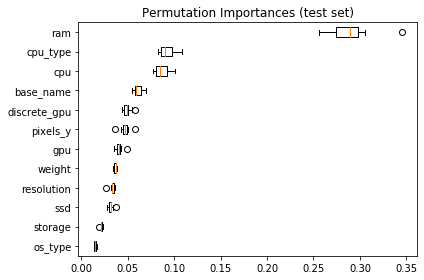

In [10]:
## Y_MAX: RANDOM FOREST REGRESSOR ##
df_pp = reformat_rfr(df_train)
X_rfr, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_rfr)
pipe_max_rfr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rfr', RandomForestRegressor(criterion="mse", max_features = .4, n_jobs=-1,
                                                   min_samples_leaf=1, max_depth=20, n_estimators=500))
                    ])
scores = cross_validate(pipe_max_rfr, X_rfr, Y_max, scoring=['neg_mean_absolute_error'], cv=10)
print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))

pipe_max_rfr.fit(X_rfr, Y_max)
var_importance(pipe_max_rfr, X_rfr, Y_max)

gemiddeld: 143.71150302911758, details: [111.68116551 196.76853141 124.78856078 143.91617637 142.3706557
 137.23794439 146.06548114 138.8709668  180.18143105 115.23411713]


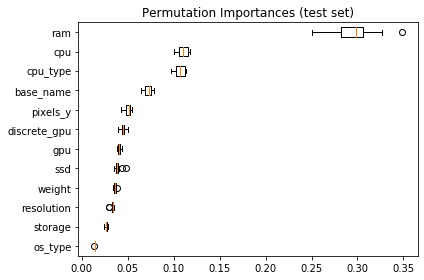

In [11]:
## Y_MIN: RANDOM FOREST REGRESSOR ##
df_pp = reformat_rfr(df_train)
X_rfr, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_rfr)
pipe_min_rfr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rfr', RandomForestRegressor(criterion="mse", max_features = .4, n_jobs=-1,
                                                   min_samples_leaf=1, max_depth=20, n_estimators=500))
                    ])
scores = cross_validate(pipe_min_rfr, X_rfr, Y_min, scoring=['neg_mean_absolute_error'], cv=10)
print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))

pipe_min_rfr.fit(X_rfr, Y_min)
var_importance(pipe_min_rfr, X_rfr, Y_min)

gemiddeld: 152.02902125493, details: [126.54746978 173.94003699 154.23828054 149.59494898 170.68566085
 146.94550277 146.81326911 146.4668464  175.20200886 129.85618829]


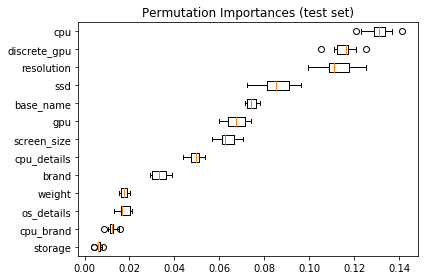

In [12]:
## Y_MAX: HUBER ##
df_pp = reformat_huber(df_train)
X_hub, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_hub)
pipe_max_huber = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rdg', HuberRegressor(2.0, alpha=.013, max_iter=2000)) #alpha:regulizer
                    ])
scores = cross_validate(pipe_max_huber, X_hub, Y_max, scoring=['neg_mean_absolute_error'], cv=10)
print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))

pipe_max_huber.fit(X_hub, Y_max)
var_importance(pipe_max_huber, X_hub, Y_max)

gemiddeld: 147.82928992037154, details: [121.30203066 171.50990219 137.50064055 147.08592731 148.90778483
 130.40179228 154.5798372  138.20217495 184.97377208 143.82903715]


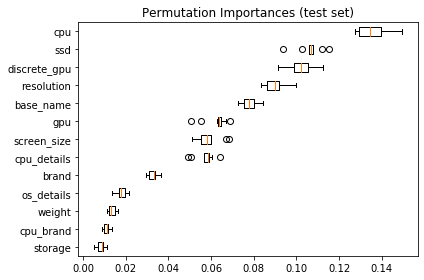

In [13]:
## Y_MIN: HUBER ##
df_pp = reformat_huber(df_train)
X_hub, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_hub)
pipe_min_huber = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rdg', HuberRegressor(2, alpha=.013, max_iter=2000)) #alpha:regulizer
                    ])
scores = cross_validate(pipe_max_huber, X_hub, Y_min, scoring=['neg_mean_absolute_error'], cv=10)
print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))

pipe_min_huber.fit(X_hub, Y_min)
var_importance(pipe_min_huber, X_hub, Y_min)

In [14]:
# 10-FOLD CROSS-VALIDATION ENSEMBLE
def ensemble_test(X1, X2, Y_max, Y_min, learner1_max, learner1_min, learner2_max, learner2_min, share1):
    # tests a weighted average ensemble in 10-fold cross-validation
    kf = KFold(n_splits=10)
    total_error = 0
    improvement = 0

    for train, val in kf.split(X1):
        X1_train, X2_train = X1.iloc[train], X2.iloc[train]
        X1_val, X2_val = X1.iloc[val], X2.iloc[val]
        Y_max_train, Y_min_train = Y_max.iloc[train], Y_min.iloc[train]
        Y_max_val, Y_min_val = Y_max.iloc[val], Y_min.iloc[val]
        learner1_max.fit(X1_train, Y_max_train)
        learner1_min.fit(X1_train, Y_min_train)
        learner2_max.fit(X2_train, Y_max_train)
        learner2_min.fit(X2_train, Y_min_train)
        df_res = pd.DataFrame()
        df_res["huber_max"] = learner1_max.predict(X1_val)
        df_res["huber_min"] = learner1_min.predict(X1_val)
        df_res["rfr_max"] = learner2_max.predict(X2_val)
        df_res["rfr_min"] = learner2_min.predict(X2_val)
        df_res["Y_max"] = np.array(Y_max_val)
        df_res["Y_min"] = np.array(Y_min_val)
        df_res["ensemble_max"] = share1 * df_res["huber_max"] + (1-share1) * df_res["rfr_max"]
        df_res["ensemble_min"] = share1 * df_res["huber_min"] + (1-share1) * df_res["rfr_min"]
        mae_huber_max = mean_absolute_error(df_res["Y_max"], df_res["huber_max"])
        mae_rfr_max = mean_absolute_error(df_res["Y_max"], df_res["rfr_max"])
        mae_ens_max = mean_absolute_error(df_res["Y_max"], df_res["ensemble_max"])
        mae_huber_min = mean_absolute_error(df_res["Y_min"], df_res["huber_min"])
        mae_rfr_min = mean_absolute_error(df_res["Y_min"], df_res["rfr_min"])
        mae_ens_min = mean_absolute_error(df_res["Y_min"], df_res["ensemble_min"])
        mae_huber = mae_huber_max + mae_huber_min
        mae_rfr = mae_rfr_max + mae_rfr_min
        mae_ens = mae_ens_max + mae_ens_min
        print("Min(Huber: {}, RFR: {}) = {}, ensemble: {}".format(mae_huber, mae_rfr, min(mae_huber, mae_rfr), mae_ens))
        improvement += min(mae_huber, mae_rfr) - mae_ens
        total_error += mae_ens
    print("error: {}, average improvement: {}".format(total_error / 10, improvement / 10))
    
ensemble_test(X1=X_hub, X2=X_rfr, Y_max=Y_max, Y_min=Y_min, learner1_max=pipe_max_huber, 
              learner1_min=pipe_min_huber, learner2_max=pipe_max_rfr, learner2_min=pipe_min_rfr, share1=0.4)

Min(Huber: 247.84950043509167, RFR: 222.32580687118246) = 222.32580687118246, ensemble: 201.36448338644522
Min(Huber: 345.4499391855901, RFR: 397.64906960213415) = 345.4499391855901, ensemble: 359.10263720492287
Min(Huber: 291.73892108996625, RFR: 264.0966101661846) = 264.0966101661846, ensemble: 256.2996182867073
Min(Huber: 296.68087628940793, RFR: 304.5411634798815) = 296.68087628940793, ensemble: 286.08901866265376
Min(Huber: 319.5934456790526, RFR: 301.771897717412) = 301.771897717412, ensemble: 282.6117706819033
Min(Huber: 277.3472950455697, RFR: 288.04821730126037) = 277.3472950455697, ensemble: 271.5358320320955
Min(Huber: 301.3931063081418, RFR: 280.2212384193388) = 280.2212384193388, ensemble: 266.53047516458224
Min(Huber: 284.66902134604607, RFR: 295.91563501832235) = 284.66902134604607, ensemble: 276.9675712822782
Min(Huber: 360.1757809411197, RFR: 353.35623599785583) = 353.35623599785583, ensemble: 341.5311473575746
Min(Huber: 273.6852254330297, RFR: 222.88078699019138) = 2

CREATE CSV FOR SEPPE

In [15]:
# turns out I am using the same reformatting and models for Y_MAX and Y_MIN, which doesn't have to be like that

df_res = pd.DataFrame()
df_res["id"]=df_test["id"]
df_res["hub_max"] = 0
df_res["hub_min"] = 0
df_res["rfr_max"] = 0
df_res["rfr_min"] = 0


NR_RUNS = 20

for run in range(NR_RUNS):
    
    ### TRAINING  ###
    
    # Huber max
    df_pp = reformat_huber(df_train)
    X_hub, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
    preprocessor = create_preprocessor(X_hub)
    pipe_max_huber = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('rdg', HuberRegressor(2.0, alpha=.013, max_iter=2000)) #alpha:regulizer
                        ])
    pipe_max_huber.fit(X_hub, Y_max)

    #Huber min
    df_pp = reformat_huber(df_train)
    X_hub, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
    preprocessor = create_preprocessor(X_hub)
    pipe_min_huber = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('rdg', HuberRegressor(2, alpha=.013, max_iter=2000)) #alpha:regulizer
                        ])
    pipe_min_huber.fit(X_hub, Y_min)

    # random forest max
    df_pp = reformat_rfr(df_train)
    X_rfr, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
    preprocessor = create_preprocessor(X_rfr)
    pipe_max_rfr = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('rfr', RandomForestRegressor(criterion="mse", max_features = .4, n_jobs=-1,
                                                       min_samples_leaf=1, max_depth=20, n_estimators=500))
                        ])
    pipe_max_rfr.fit(X_rfr, Y_max)

    # random forest min
    df_pp = reformat_rfr(df_train)
    X_rfr, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
    preprocessor = create_preprocessor(X_rfr)
    pipe_min_rfr = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('rfr', RandomForestRegressor(criterion="mse", max_features = .4, n_jobs=-1,
                                                       min_samples_leaf=1, max_depth=20, n_estimators=500))
                        ])
    pipe_min_rfr.fit(X_rfr, Y_min)


    ### PREDICTIONS  ###


    # Huber max
    X_hub_test = reformat_huber(df_test)
    df_res["hub_max"] += pipe_max_huber.predict(X_hub_test)
    # Huber min
    X_hub_test = reformat_huber(df_test)
    df_res["hub_min"] += pipe_min_huber.predict(X_hub_test)
    # random forest max
    X_rfr_test = reformat_rfr(df_test)
    df_res["rfr_max"] += pipe_max_rfr.predict(X_rfr_test)
    # random forest min
    X_rfr_test = reformat_rfr(df_test)
    df_res["rfr_min"] += pipe_min_rfr.predict(X_rfr_test)

    
# compute final results
SHARE = 0.4
df_res["pred_max"] = (SHARE * df_res["hub_max"] + (1-SHARE) * df_res["rfr_max"]) / NR_RUNS
df_res["pred_min"] = (SHARE * df_res["hub_min"] + (1-SHARE) * df_res["rfr_min"]) / NR_RUNS
df_res["pred_max"] = df_res[["pred_max", "pred_min"]].max(axis=1)

# produce csv
seppe_cols = ["id","pred_min","pred_max"]

print(df_res[seppe_cols].head(20))
df_res[seppe_cols].to_csv('group1.csv', sep=",", index=False)


       id     pred_min     pred_max
0   28807  1124.939332  1207.896691
1   22559   369.678448   386.442977
2   28647   840.060415   858.232260
3   22141   578.353261   593.090954
4   26116  1859.424104  1967.414965
5   27111  1339.355048  1359.705266
6   23420   615.770827   647.419125
7   21464   138.230318   139.807073
8   29405   630.178953   657.192418
9   27107   426.021758   440.269932
10  26141   833.843925   887.578966
11  25928  1666.343197  1785.074204
12  24845   658.516454   735.562703
13  28804   287.852832   301.994973
14  26772   567.875048   574.837888
15  27413   912.046111   945.428124
16   7261   806.853736   857.612790
17  31424   801.898588   812.856935
18   3940   403.768153   406.445388
19  16238   535.086231   538.152162


COMMENTS FOR REPORT
Huber: schnell
RandaomForestRegressor: zeer stochastische resultaten ?, langzaam
Verschillende parameters -> hoop op ensemble, want verschillend
RFR: mae slechter als mse??
pixels_x, pixels_Y (clearly share in permutation var importance), resolution, screen_size
Permutation variance not best guidance -> trial & error
Gave up points for model simplicity
ram niet daar in huber, belangrijk in rfr

IDEAS
shuffle data for different training runs
predict the min price (easier than max price), then the difference (delta_abs or delta_rel)
different preprocessors, models
learning: include levels test set -> no unknowns! Possible to to embedding / OrdinalEncoder then?
PCA nog eens proberen?
unsupervised technique

NOT USED: ENSEMBLE WITH WEIGHTS COMPUTED BY LINEAR REGRESSION MODEL

In [ ]:
df_win = pd.DataFrame()
df_win["id"] = df_train["id"]
df_win["huber_max"] = pipe_max_huber.predict(X_hub)
df_win["rfr_max"] = pipe_max_rfr.predict(X_rfr)
df_win["Y_max"] = np.array(Y_max)
df_win["huber_err_max"] = (df_win["huber_max"] - df_win["Y_max"]).abs()
df_win["rfr_err_max"] = (df_win["rfr_max"] - df_win["Y_max"]).abs()
df_win["huber_wins_max"] = df_win["huber_err_max"] < df_win["rfr_err_max"]
df_win["huber_min"] = pipe_min_huber.predict(X_hub)
df_win["rfr_min"] = pipe_min_rfr.predict(X_rfr)
df_win["Y_min"] = np.array(Y_min)
df_win["huber_err_min"] = (df_win["huber_min"] - df_win["Y_min"]).abs()
df_win["rfr_err_min"] = (df_win["rfr_min"] - df_win["Y_min"]).abs()
df_win["huber_wins_min"] = df_win["huber_err_min"] < df_win["rfr_err_min"]
all_cols = set (X_hub) | set(X_rfr)# list of cols used in X_hub and X_rfr
print(df_win.head(10))

In [ ]:
## WHO WINS MAX LOGISTIC REGRESSION##
def reformat_wins_max_lr(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    drop_cols = ["cpu", "cpu_type", "cpu_brand", "discrete_gpu", "pixels_y", "base_name",
                "screen_size", "storage", "ram", "weight", "cpu_details", "brand",
                "ssd", "os_details", "os_type"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .83)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [ ]:
## WHO WINS MAX LOGISTIC REGRESSION##
X_win_max = reformat_wins_max_lr(df_train)
X_win_max = X_win_max[np.intersect1d(list(X_win_max), list(all_cols))]
Y_win_max = df_win["huber_wins_max"]
preprocessor = create_preprocessor(X_win_max)
pipe_win_max_lr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('lr', LogisticRegression(penalty="l1", solver="saga", C=1.3, max_iter=2000))
                    ])
scores = cross_validate(pipe_win_max_lr, X_win_max, Y_win_max, cv=10)
print("gemiddeld: {}, details: {}".format(np.mean(scores['test_score']), scores['test_score']))

pipe_win_max_lr.fit(X_win_max, Y_win_max)
var_importance(pipe_win_max_lr, X_win_max, Y_win_max)

In [ ]:
## WHO WINS MIN LOGISTIC REGRESSION##
def reformat_wins_min_lr(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    drop_cols = ["discrete_gpu", "cpu_brand", "pixels_y", "os_type", "cpu_type", "ram",
                "ssd", "screen_size", "resolution", "weight", "os_details", "storage",
                "base_name", "brand", "cpu", "cpu_details"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .83)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [ ]:
## WHO WINS MIN LOGISTIC REGRESSION##
X_win_min = reformat_wins_min_lr(df_train)
X_win_min = X_win_min[np.intersect1d(list(X_win_min), list(all_cols))]
Y_win_min = df_win["huber_wins_min"]
preprocessor = create_preprocessor(X_win_min)
pipe_win_min_lr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('lr', LogisticRegression(penalty="l1", solver="saga", C=.7))
                    ])
scores = cross_validate(pipe_win_min_lr, X_win_min, Y_win_min, cv=10)
print("gemiddeld: {}, details: {}".format(np.mean(scores['test_score']), scores['test_score']))

pipe_win_min_lr.fit(X_win_min, Y_win_min)
var_importance(pipe_win_min_lr, X_win_min, Y_win_min)

In [ ]:
# 10-FOLD CROSS-VALIDATION ENSEMBLE WITH VARIABLE WEIGHTS
def ensemble_test(X1, X2, Y_max, Y_min, learner1_max, learner1_min, learner2_max, learner2_min, 
                  X_win_max, Y_win_max, learner_win_max, X_win_min, Y_win_min, learner_win_min):
    # tests a weighted average ensemble in 10-fold cross-validation
    kf = KFold(n_splits=10)
    total_error = 0
    improvement = 0

    for train, val in kf.split(X1):
        X1_train, X2_train, X_win_max_train, X_win_min_train = X1.iloc[train], X2.iloc[train], X_win_max.iloc[train], X_win_min.iloc[train]
        X1_val, X2_val, X_win_max_val, X_win_min_val = X1.iloc[val], X2.iloc[val],  X_win_max.iloc[val], X_win_min.iloc[val]
        Y_max_train, Y_min_train, Y_win_max_train, Y_win_min_train = Y_max.iloc[train], Y_min.iloc[train],  Y_win_max.iloc[train], Y_win_min.iloc[train]
        Y_max_val, Y_min_val, Y_win_max_val = Y_max.iloc[val], Y_min.iloc[val], Y_win_max.iloc[val]
        learner1_max.fit(X1_train, Y_max_train)
        learner1_min.fit(X1_train, Y_min_train)
        learner2_max.fit(X2_train, Y_max_train)
        learner2_min.fit(X2_train, Y_min_train)
        learner_win_max.fit(X_win_max_train, Y_win_max_train)   
        learner_win_min.fit(X_win_min_train, Y_win_min_train)  
        df_res = pd.DataFrame()
        df_res["huber_max"] = learner1_max.predict(X1_val)
        df_res["huber_min"] = learner1_min.predict(X1_val)
        df_res["rfr_max"] = learner2_max.predict(X2_val)
        df_res["rfr_min"] = learner2_min.predict(X2_val)
        shares_max = learner_win_max.predict_proba(X_win_max_val)
        df_res["huber_prob_max"] = shares_max[:,1]
        df_res["rfr_prob_max"] = shares_max[:,0]
        shares_min = learner_win_min.predict_proba(X_win_min_val)
        df_res["huber_prob_min"] = shares_min[:,1]
        df_res["rfr_prob_min"] = shares_min[:,0]
        df_res["Y_max"] = np.array(Y_max_val)
        df_res["Y_min"] = np.array(Y_min_val)
        df_res["ensemble_max"] = df_res["huber_prob_max"] * df_res["huber_max"] + df_res["rfr_prob_max"] * df_res["rfr_max"]
        df_res["ensemble_min"] = df_res["huber_prob_min"] * df_res["huber_min"] + df_res["rfr_prob_min"] * df_res["rfr_min"]
        mae_huber_max = mean_absolute_error(df_res["Y_max"], df_res["huber_max"])
        mae_rfr_max = mean_absolute_error(df_res["Y_max"], df_res["rfr_max"])
        mae_ens_max = mean_absolute_error(df_res["Y_max"], df_res["ensemble_max"])
        mae_huber_min = mean_absolute_error(df_res["Y_min"], df_res["huber_min"])
        mae_rfr_min = mean_absolute_error(df_res["Y_min"], df_res["rfr_min"])
        mae_ens_min = mean_absolute_error(df_res["Y_min"], df_res["ensemble_min"])
        mae_huber = mae_huber_max + mae_huber_min
        mae_rfr = mae_rfr_max + mae_rfr_min
        mae_ens = mae_ens_max + mae_ens_min
        print("Min(Huber: {}, RFR: {}) = {}, ensemble: {}".format(mae_huber, mae_rfr, min(mae_huber, mae_rfr), mae_ens))
        improvement += min(mae_huber, mae_rfr) - mae_ens
        total_error += mae_ens
    print("error: {}, average improvement: {}".format(total_error / 10, improvement / 10))
    
ensemble_test(X1=X_hub, X2=X_rfr, Y_max=Y_max, Y_min=Y_min, learner1_max=pipe_max_huber, 
              learner1_min=pipe_min_huber, learner2_max=pipe_max_rfr, learner2_min=pipe_min_rfr,
              X_win_max=X_win_max, Y_win_max=Y_win_max, learner_win_max=pipe_win_max_lr,
              X_win_min=X_win_min, Y_win_min=Y_win_min, learner_win_min=pipe_win_min_lr)

NOT USED: MLP

In [ ]:
# neural network imports
from sklearn.base import TransformerMixin
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers
from keras.regularizers import l1_l2
from keras.models import load_model

In [ ]:
class MLP_custom(TransformerMixin):
    def __init__(self, nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', l1=0.0001, l2=0.0001,
                 input_shape=0, validation_split=.3, patience=3):
        self.nd = nodes
        self.ep = epochs
        self.bs= batch_size
        self.metric = metric
        self.l1 = l1
        self.l2 = l2
        self.vs = validation_split
        self.pat = patience
        
        # model
        inputs = Input(shape=(input_shape,))  # was 1196
        dense = Dense(self.nd, activity_regularizer=l1_l2(self.l1, self.l2), 
                      activation="relu", kernel_initializer='Orthogonal')(inputs)
        output = Dense(1, activation="relu")(dense)
        self.model = Model(inputs=inputs, outputs=output)
        self.model.compile(loss = self.metric, optimizer = 'adadelta', metrics=[self.metric])
        
        #callbacks
        self.es = EarlyStopping(monitor='val_'+metric, mode='min', verbose=1, patience=self.pat)
        self.mc = ModelCheckpoint('best_model.h5', monitor='val_'+metric, mode='min', verbose=0, save_best_only=True)
        
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.model.fit(X, Y, epochs=self.ep, batch_size=self.bs, callbacks=[self.es, self.mc], 
                       validation_split=self.vs, verbose=0)    
        self.model = load_model('best_model.h5')

    
    def transform(self, X):
        return self.model.predict(X)
    
    
    def predict(self, X):
        return self.model.predict(X)


In [ ]:
## MLP ##
def reformat_mlp(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols = ["gpu_series", "detachable_keyboard", "pixels_x", "weight", "touchscreen", "id",
                "name", "screen_surface", "cpu_brand", "os_type", "os_details",
                "ram", "base_name", "brand", "storage", "os", "os_nr", "discrete_gpu",
                "resolution", "ssd"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .99)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [ ]:
## Y_MAX: MLP ##
df_pp = reformat_mlp(df_train)
X_mlp, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_mlp)

'''
# cross-validation                    
kf = KFold(n_splits=3)
total_error = []
for train, val in kf.split(X_mlp):
        X_mlp_train = X_mlp.iloc[train]
        X_mlp_val = X_mlp.iloc[val]
        Y_max_train, Y_min_train = Y_max.iloc[train], Y_min.iloc[train]
        Y_max_val = Y_max.iloc[val]
        input_shape_cv  = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp_train).shape[1]
        pipe_max_mlp_CV = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', 
                            l1=0.0001, l2=0.0001, input_shape=input_shape_cv, validation_split=.3, patience=3)) 
                    ])
        pipe_max_mlp_CV.fit(X_mlp_train, Y_max_train)
        df_res = pd.DataFrame()
        predictions = pipe_max_mlp_CV.predict(X_mlp_val) # is list of lists, must be converted
        predictions = [x[0] for x in predictions]
        df_res["mlp_max"] = predictions
        df_res["Y_max"] = np.array(Y_max_val)
        mae_mlp_max = mean_absolute_error(df_res["Y_max"], df_res["mlp_max"])
        total_error.append(mae_mlp_max)
print("gemiddeld: {}, details: {}".format(np.mean(total_error), total_error))

# training and feature importance

input_shape = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp).shape[1]
pipe_max_mlp = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', 
                            l1=0.0001, l2=0.0001, input_shape=input_shape, validation_split=.3, patience=3)) 
    ])

pipe_max_mlp.fit(X_mlp, Y_max)
var_importance(pipe_max_mlp, X_mlp, Y_max, scoring="neg_mean_absolute_error")
'''

# feature importance on last k-fold
idx = range(len(X_mlp))
idx = np.random.permutation(idx)
X_mlp_train, X_mlp_val = X_mlp.iloc[idx[:400]], X_mlp.iloc[idx[400:]]
Y_max_train, Y_max_val = Y_max.iloc[idx[:400]], Y_max.iloc[idx[400:]]
input_shape  = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp_train).shape[1]
pipe_max_mlp = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=10, epochs=200, batch_size=128, metric='mean_absolute_error', 
                            l1=0.00001, l2=0.0005, input_shape=input_shape, validation_split=.2, patience=3)) 
    ])
pipe_max_mlp.fit(X_mlp_train, Y_max_train)
df_res = pd.DataFrame()
predictions = pipe_max_mlp.predict(X_mlp_val) # is list of lists, must be converted
predictions = [x[0] for x in predictions]
df_res["mlp_max"] = predictions
df_res["Y_max"] = np.array(Y_max_val)
mae_mlp_max = mean_absolute_error(df_res["Y_max"], df_res["mlp_max"])
print("error:",mae_mlp_max)

var_importance(pipe_max_mlp, X_mlp_train, Y_max_train, scoring="neg_mean_absolute_error")